In [1]:
import sys
sys.path.append('../')

import json
from instruments.swap import *
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

## Market Curves

In [2]:
class Market:
    def __init__(self) -> None:
        self.market_dfs = pd.read_csv('../data/markets/Market_2023_09_29_DFs.csv', 
                                        skiprows= 2,
                                        on_bad_lines='skip')
        self.evaluation_date = date(2023,9,29)
        self._eur_6m_index_init()
    
    @property
    def estr_curve(self):
        df_eur = self.market_dfs[self.market_dfs['Property'].str.contains("IR.EUR-ESTR-ON.DF")][['Property', 'Label']]
        dates = []
        for i in range(len(df_eur['Property'].values)):
            str_temp = df_eur['Property'].values[i][18:29]
            dates.append(datetime.strptime(str_temp, '%d-%b-%Y') )
        dfs_pillars = [(dates[t]-dates[0]).days/365 for t in range(len(dates))]
        dfs_market = df_eur['Label'].values
        return DiscountCurveSimple(dfs_pillars, dfs_market)
    
    def _eur_6m_index_init(self):
        index_eur_6m = CurveRateIndex("EUR6M", "calendar", self.estr_curve, "6M")
        # fixing storici settati costanti a 3% 
        dates_random = [date(2023,9,28) - timedelta(x) for x in range(0,200)] 
        [index_eur_6m.add_fixing(dt, 0.03) for dt in dates_random]
        self._eur_6m_index = index_eur_6m 
    
    @property
    def eur_6m_index(self):
        return self._eur_6m_index
    

## market instance
md = Market()

## Trades

In [3]:
def make_swap(trade):
    ''' 
    Read json and returns tq.Swap
    '''
    leg1_schedule_len = len(trade['data']['Leg1.schedule']['rows'])
    leg2_schedule_len = len(trade['data']['Leg2.schedule']['rows'])

    leg1_is_fixed = trade['data']['Leg1.isFixedLeg']
    leg2_is_fixed = trade['data']['Leg2.isFixedLeg']

    if not leg1_is_fixed:
        leg1_index = trade['data']['Leg1.index']
    elif not leg2_is_fixed:
        leg2_index = trade['data']['Leg2.index']

    date_format = '%Y-%m-%d'
    leg1_payment_dates = [trade['data']['Leg1.schedule']['rows'][i]['paymentDate'] for i in range(leg1_schedule_len)]
    leg1_payment_dates = [datetime.strptime(dt, date_format).date() for dt in leg1_payment_dates]
    leg2_payment_dates = [trade['data']['Leg2.schedule']['rows'][i]['paymentDate'] for i in range(leg2_schedule_len)]
    leg2_payment_dates = [datetime.strptime(dt, date_format).date() for dt in leg2_payment_dates]

    leg1_notionals = [trade['data']['Leg1.notionalTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_notionals = [trade['data']['Leg2.notionalTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_margins = [trade['data']['Leg1.marginTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_margins = [trade['data']['Leg2.marginTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_rate_factor = [trade['data']['Leg1.rateFactorTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_rate_factor = [trade['data']['Leg2.rateFactorTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]

    leg1_fixed_payments = [trade['data']['Leg1.fixedPaymentAmountTable']['rows'][i]['value'] for i in range(leg1_schedule_len)]
    leg2_fixed_payments = [trade['data']['Leg2.fixedPaymentAmountTable']['rows'][i]['value'] for i in range(leg2_schedule_len)]


    if leg1_is_fixed and not leg2_is_fixed:

        if leg2_index == 'EUR-EURIBOR-6M':
            index = md.eur_6m_index
        else:
            raise ValueError('No index available')

        swap_obj = SwapFixedFloating(leg1_payment_dates,
                                    leg2_payment_dates,
                                    leg1_notionals,
                                    leg2_notionals ,
                                    leg2_rate_factor, # moltiplicatore variabile
                                    leg2_margins, # spread variabile
                                    index,
                                    leg1_margins) # tasso fisso
        
    elif leg2_is_fixed and not leg1_is_fixed:
        if leg1_index == 'EUR-EURIBOR-6M':
            index = md.eur_6m_index
        else:
            raise ValueError('No index available')

        swap_obj = SwapFixedFloating(leg1_payment_dates,
                                    leg2_payment_dates,
                                    leg1_notionals,
                                    leg2_notionals,
                                    leg1_rate_factor, # moltiplicatore variabile
                                    leg1_margins, # spread variabile
                                    index,
                                    leg2_margins) # tasso fisso
    
    return swap_obj

def make_portfolio(trade_data):
    portfolio = []
    errors = []
    for trade_json in trade_data:
        try:
            if trade_json['data']['productType'] == 'InterestRateSwapScript':
                trade_json['trade_object'] = make_swap(trade_json)
                portfolio.append(trade_json)
        except:
            errors.append(trade_json['ref'])
    return portfolio, errors

def price_portfolio(portfolio: list, market: Market):
    ''' 
    prezza un portafoglio dato un mercato
    '''
    portfolio_prices = []
    portfolio_trade_id = []
    pricing_errors = []
    for trade in portfolio:
        if trade['data']['currency'] == 'EUR':
            try:
                portfolio_prices.append(trade['trade_object'].price(market.estr_curve, market.evaluation_date).numpy())
                portfolio_trade_id.append(trade['ref'])
            except:
                pricing_errors.append(trade['ref'])

    portfolio_results = pd.DataFrame([portfolio_trade_id,
                                  portfolio_prices]).T
    portfolio_results.columns = ['ID', 'PRICE']

    return portfolio_results, pricing_errors

In [4]:
md = Market()
with open('../data/trades/TradesAggregated_2.json', 'r') as file:
    trade_data = json.load(file)

# filtro per ATLANDES
# for trade_json in trade_data:
#     if trade_json['ref'] == '0-17092454':
#         trade = trade_json
# trade['data']['cpty']
    
ptf, mapping_errors = make_portfolio(trade_data)

In [5]:
ptf_results, pricing_errors =  price_portfolio(ptf, md)

# test xva singolo trade

In [6]:
from models.hullwhitesimple import *
from engines.gaussian1d import *

In [7]:
#filtro per ATLANDES
for trade_json in trade_data:
    if trade_json['ref'] == '0-17092454':
        trade = trade_json
print(trade['data']['cpty'])
swap_obj = make_swap(trade)
npv = swap_obj.price(md.estr_curve, md.evaluation_date) 
npv_float = swap_obj.floating_leg.npv(md.estr_curve, md.evaluation_date) 
npv_fixed = swap_obj.fixed_leg.npv(md.estr_curve, md.evaluation_date) 

print(f"NPV TQ: {npv :,.0f}")
print(f"NPV FixedLeg TQ: {npv_fixed :,.0f}")
print(f"NPV FloatingLeg TQ: {npv_float :,.0f}")

ATLANDES_SA
NPV TQ: -10,478,948
NPV FixedLeg TQ: -46,972,945
NPV FloatingLeg TQ: 36,493,997


In [8]:
mean_rev = 0.02
sigma = 0.045
hw = HullWhiteProcess(mean_rev, sigma, market_curve=md.estr_curve)


last_grid_time = 20
time_steps = 50
n_path = 1000
hw_kernel = GaussianRateKernel1D(hw)
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(n_path, last_grid_time, time_steps)


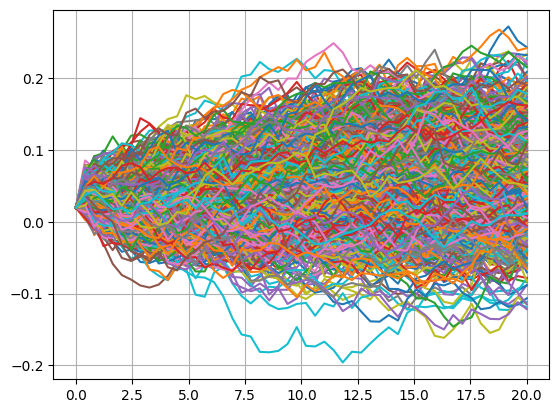

In [9]:
plt.plot(grid, r_tensor)
plt.grid()
plt.show()

In [10]:
# Reshape the tensor
reshaped_tensor = tf.transpose(zb_tensor, perm=[1, 2, 0])  # Transpose the dimensions
reshaped_tensor = tf.reshape(reshaped_tensor, shape=(zb_tensor.shape[1], zb_tensor.shape[2], zb_tensor.shape[0]))
rate_curve_tensor = RateCurveSimple(md.estr_curve.pillars, reshaped_tensor)

In [11]:
grid_dates = [md.evaluation_date + timedelta(int(t*365)) for t in grid]
xva_ptf = [swap_obj]

i = 1
grid_evaluation_date = grid_dates[i]
grid_date_r_tensor = r_tensor[i-1]
grid_date_zb_tensor = zb_tensor[i-1]
grid_date_curve_tensor = RateCurveSimple(md.estr_curve.pillars, grid_date_zb_tensor)
# add fixing da rivedere, statici con ultimo valore simulato
dates_random = [grid_evaluation_date - timedelta(x) for x in range(0,100)] 
for dt in dates_random:
    md.eur_6m_index.add_fixing(dt, tf.reduce_mean(grid_date_r_tensor).numpy()) 
# link curves to discounting-forwarding
path_exposure = [deal.price(grid_date_curve_tensor, grid_evaluation_date) for deal in xva_ptf ]



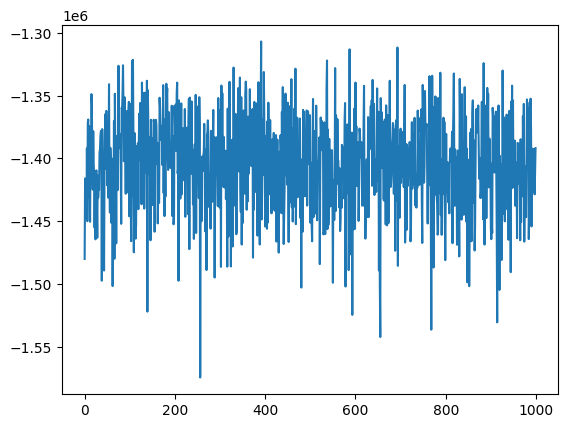

In [12]:
plt.plot(path_exposure[0].numpy());

In [55]:
for i in range(len(grid_dates)):
    grid_evaluation_date = grid_dates[i]
    grid_date_r_tensor = r_tensor[i-1]

In [48]:
grid_dates

[datetime.date(2023, 9, 29),
 datetime.date(2024, 2, 24),
 datetime.date(2024, 7, 22),
 datetime.date(2024, 12, 18),
 datetime.date(2025, 5, 16),
 datetime.date(2025, 10, 12),
 datetime.date(2026, 3, 10),
 datetime.date(2026, 8, 6),
 datetime.date(2027, 1, 2),
 datetime.date(2027, 5, 31),
 datetime.date(2027, 10, 27),
 datetime.date(2028, 3, 24),
 datetime.date(2028, 8, 20),
 datetime.date(2029, 1, 16),
 datetime.date(2029, 6, 14),
 datetime.date(2029, 11, 10),
 datetime.date(2030, 4, 8),
 datetime.date(2030, 9, 4),
 datetime.date(2031, 1, 31),
 datetime.date(2031, 6, 29),
 datetime.date(2031, 11, 25),
 datetime.date(2032, 4, 22),
 datetime.date(2032, 9, 18),
 datetime.date(2033, 2, 14),
 datetime.date(2033, 7, 13),
 datetime.date(2033, 12, 9),
 datetime.date(2034, 5, 7),
 datetime.date(2034, 10, 3),
 datetime.date(2035, 3, 1),
 datetime.date(2035, 7, 28),
 datetime.date(2035, 12, 24),
 datetime.date(2036, 5, 21),
 datetime.date(2036, 10, 17),
 datetime.date(2037, 3, 15),
 datetime.dat

In [50]:
r_tensor[0]

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.01979834, 0.01979834, 0.01979834, 0.01979834, 0.01979834,
       0.0197

In [42]:
r_tensor

<tf.Variable 'Variable:0' shape=(50, 1000) dtype=float64, numpy=
array([[ 0.01979834,  0.01979834,  0.01979834, ...,  0.01979834,
         0.01979834,  0.01979834],
       [ 0.05318743,  0.04177389,  0.04656547, ...,  0.02139574,
         0.03536399,  0.02340514],
       [ 0.0290734 ,  0.03945603,  0.05632257, ...,  0.00736587,
         0.02206335,  0.01718036],
       ...,
       [ 0.07513193,  0.01432451,  0.11563781, ...,  0.06288502,
         0.02110546,  0.0009025 ],
       [ 0.08561111,  0.02093786,  0.12941902, ...,  0.06832554,
         0.00721392,  0.01481811],
       [ 0.07483896,  0.01453048,  0.13898258, ...,  0.06886522,
        -0.0005286 ,  0.01580719]])>

In [44]:
len(grid_dates)

50